# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

configuration = {'files': {'training': './project.data/train.p',
                           'testing': './project.data/test.p',
                           'sign_labels': './project.data/signnames.csv',
                           'normalized_training': './project.data/norm.train.p',
                           'normalized_testing': './project.data/norm.test.p'
                           }
                 }


def read_data_from_files(config, normalized=False):
    """ Read from files the training and testing data sets
    :param config: a dictionary containing a 'files' key, with the filenames needed
    :param normalized: if true load the normalized files
    :return: returns training and testing datasets with labels
    """
    if normalized is False:
        training_file = config['files']['training']
        testing_file = config['files']['testing']
        signs_file = config['files']['sign_labels']
    else:
        training_file = config['files']['normalized_training']
        testing_file = config['files']['normalized_testing']
        signs_file = config['files']['sign_labels']
    try:
        with open(training_file, mode='rb') as f:
            train_set = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)
        with open(signs_file, mode='r') as f:
            signs = csv.reader(f)
            next(signs)  # skip the first row which as headers
            label_signs = {int(rows[0]): rows[1] for rows in signs}

        return train_set['features'], train_set['labels'], test['features'], test['labels'], label_signs

    except Exception as e:
        print(e)
        print(e.args)
        quit()


def save_object_to_file(obj, filename):
    """
    Save object to filename
    :param obj: the object we want to save
    :param filename: the filename to save
    :return: None
    """
    try:
        with open(filename, mode='wb') as f:
            pickle.dump(obj, f)
    except Exception as e:
        print(e)
        print(e.args)
        quit()


X_train, y_train, X_test, y_test, sign_labels = read_data_from_files(configuration)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Part 2: Data Summary 

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

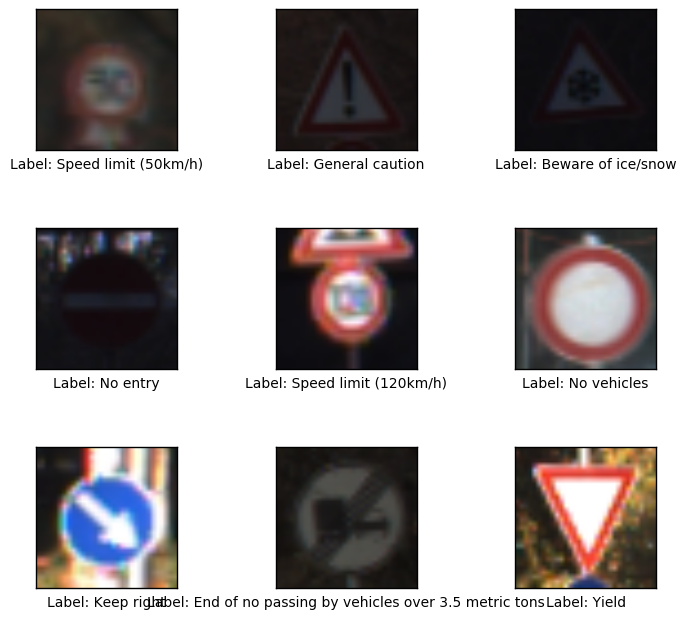

In [3]:
# Part 3: Data exploration visualization goes here.

import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
% matplotlib inline


def plot_random_images(images, rows, columns, labels, captions, predicted_label=None, cmap=None):
    """
    Creates a figure grid with images from the provided dataset with labels as titles
    :param images: an ndarray with images
    :param rows: no of grid rows
    :param columns: no of column rows
    :param labels: an ndarray provind the corresponding image labels as a number encoding
    :param captions: the textual interpretation of the image
    :param predicted_label: if this is given then we show the predicted label
    :param cmap: the colormap used to draw the images
    :return: None
    """
    # no check for edge cases where images are much less than rows and/or rows*columns
    no_images = min(len(images), rows * columns)
    images_to_plot = np.random.choice(len(images), no_images, replace=False)

    figure = plt.figure()
    figure = plt.figure(figsize=(8, 8), dpi= 80)
    figure.subplots_adjust(wspace=0.7, hspace=0.2)
    for index in range(0, no_images):
        image_index = images_to_plot[index]
        image = images[image_index]
        image_label = labels[images_to_plot[index]]

        if predicted_label is None:
            image_caption = "Label: {0}".format(captions[image_label])
        else:
            image_prediction = predicted_label[images_to_plot[index]]
            image_caption = "Label: {0}, Pred: {1}".format(captions[image_label], captions[image_prediction])

        subplot = figure.add_subplot(rows, columns, index + 1)
        subplot.set_xlabel(image_caption, fontsize=10)
        subplot.set_xticks([])
        subplot.set_yticks([])
        plt.imshow(image, cmap=cmap)
    plt.show()


plot_random_images(X_train, 3, 3, y_train, sign_labels)

---

### Notice

A histogram of the distribution of number of images per traffic sign will be shown a little bit later when we will generate new images in order to make the distribution uniform

---

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
# Part 4: Preprocess Data-----------------------------------------------------------------------------------------------


import cv2


# return a gray scale version of the original image
def grayscale(image):
    """
    create a grayscale version of the original image
    :param image: a colored image as an nparray
    :return: a grayscale version of the original image
    """
    converted = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return converted


# rescale image date from [0, 255] to [-0.5,0.5]
def normalize(image_data):
    """
    normalize image data by first scaling to [0,1] by dividing with 255
    and then centering the values around zero [-0.5, 0.5]
    :param image_data: an images as an nparray
    :return: normalized image as an nparray
    """
    return image_data / 255 - 0.5


# pre process the image by applying first grayscale and then normalizing
def pre_process(image):
    """
    provide a grayscale and normalized version of an image
    :param image: an image as an nparray
    :return: a grayscale and normalized image array
    """
    return normalize(grayscale(image))


def pre_process_dataset(sample):
    """
    preprocess a sample set of images
    :param sample: an nparray holding many images
    :return: an nparray holding the images processed
    """
    return np.asarray([pre_process(image) for image in sample])


normalized_X_train = pre_process_dataset(X_train)
normalized_X_test = pre_process_dataset(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** All images were converted to grayscale and then normalized. Normalization was just "mapping" the values from [0,255] to [-0.5,0.5]

* Removing color information : Changes in light conditions , result in changes in color information. Keeping the color information would just require a bigger and more complex network that would eventually learn to ignore color information. Although the signs are color coded , by the legislator , that information would be helpfull if we were designing a network to map signs to "sign categories" (information signs, danger signs... etc)

* Normalizing by centering values around zero is just to remove any statistical skew in the first few training iterations. Weights, biases and image data will be zero centered


### Generate more Image Data

the following is basically based on code as seen on [this notebook](https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb)

First we explore the distribution of number of images per traffic sign and then generate new images in order to make the distribution uniform.
This is **important** for the prediction error distribution to be uniform. If this step is omitted the accuracy predictions would be biased

* First Create a function that would generate new images by rotating - skewing and translating an image randomly with some limits

In [5]:
# Part 5: Generate more Data -------------------------------------------------------------------------------------------


def transform_image(img, ang_range, shear_range, trans_range):
    """
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation
    """

    # taking care of the case where we are using grayscale images
    if len(img.shape) == 3:
        rows, cols, ch = img.shape
    else:
        rows, cols = img.shape

    # Rotation
    if ang_range != 0:
        ang_rot = np.random.uniform(ang_range) - ang_range / 2
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)
        img = cv2.warpAffine(img, rotation_matrix, (cols, rows))

    # Translation
    if trans_range != 0:
        tr_x = trans_range * np.random.uniform() - trans_range / 2
        tr_y = trans_range * np.random.uniform() - trans_range / 2
        translation_matrix = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
        img = cv2.warpAffine(img, translation_matrix, (cols, rows))

    # Shear
    if shear_range != 0:
        pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

        pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
        pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

        pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

        shear_matrix = cv2.getAffineTransform(pts1, pts2)
        img = cv2.warpAffine(img, shear_matrix, (cols, rows))

    return img


* Before generating images we need to know how many to generate. We generate as many "needed"
* Needed is "as many as to have an even distribution" of images

The **signs_distrbution** takes as argument tha data labels of the training set and "counts" the number of images per category.
It returns a list with the number of images per category

We then *plot the histogram* with the plot_histogram function



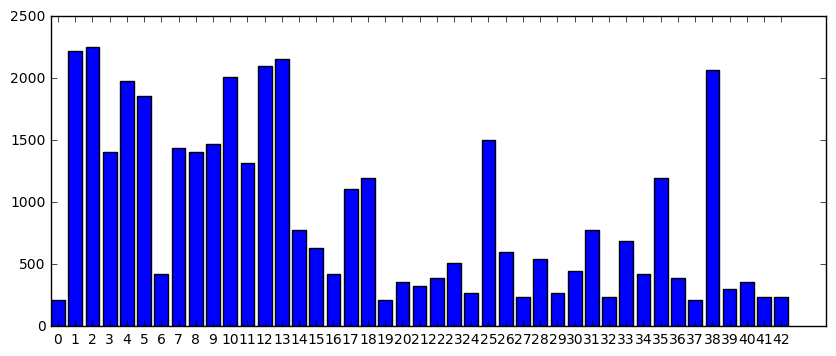

In [6]:
# create more data so each label category has the same data size

from collections import Counter
from math import floor


def plot_histogram(labels, quantities):
    """
    Create a bar histogram to visualize the distribution of number of images
    per sign class
    :param labels: an ordinal list with all the sign classes
    :param quantities: the number of images per sign class
    :return: None
    """
    indexes = np.arange(len(labels))
    width = 0.8

    # plotting the histogram
    plt.figure(figsize=(10, 4), dpi=80)
    plt.bar(indexes, quantities, width)
    plt.rc('xtick', labelsize=10)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()


def signs_distribution(signs):
    """
    :param signs: the data labels of the dataset
    :return: a tuple (code_labels, quantities_per_label)
    """
    ctr = Counter(sorted(signs))
    code_labels, quantities_per_label = zip(*(ctr.items()))
    return code_labels, quantities_per_label


code_labels, quantities_per_label = signs_distribution(y_train)
target_quantities_per_label = 1.0 * max(quantities_per_label)

# how many images i want per sign class
# if we use 1.0 , the traffic sign class with max number of images will not generate new content


# plotting the distribution before data generation
plot_histogram(code_labels, quantities_per_label)

Now that we know the distribution of the trafic signs in the training data we can generate new images to make a uniform distribution.


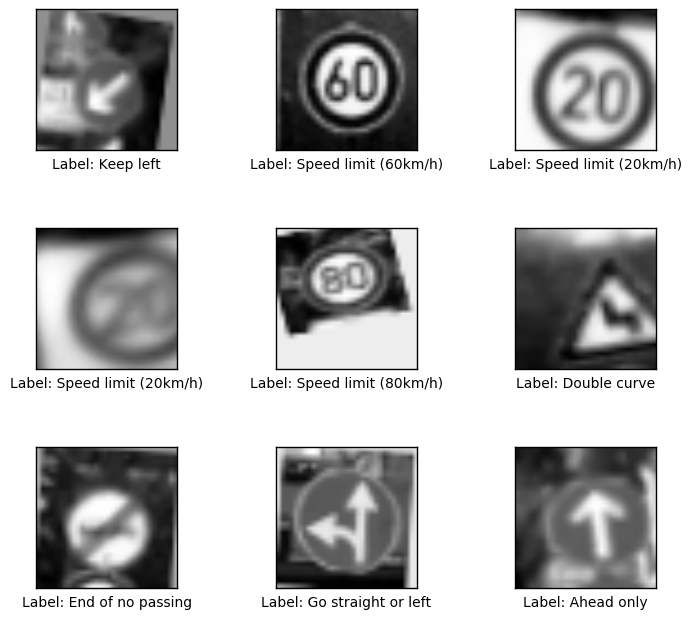

In [7]:
def generate_images_for_class(images, labels, image_class, target_value, transformations_per_image):
    """
    generate new images for a specific sing class
    :param images: the image dataset
    :param labels: the corresponding labels dataset
    :param image_class: the sign class i want to generate new images for
    :param target_value: the number of new images i want to generate (for an even distribution)
    :param transformations_per_image: how many images should i create from a single image
    :return: a tuple (new_images, new_labels)
    """
    # create a view of images of the selected class
    image_pool = images[labels[:] == image_class]
    # calculate the number of images to generate
    images_to_generate = int(floor((target_value - len(image_pool)) / transformations_per_image))
    # pick random images from the image pool
    images_to_transform = np.random.choice(len(image_pool), images_to_generate, replace=False)

    generated_images = []
    generated_labels = []

    for index in images_to_transform:
        for i in range(0, transformations_per_image):
            generated_images.append(transform_image(image_pool[index], 0, 10, 0))
            generated_labels.append(image_class)
    return generated_images, generated_labels


def generate_images(images, image_labels, sign_classes, images_per_class, transformations_per_image=10):
    """
    Generate images for all sign classes as needed
    :param images: the image dataset
    :param image_labels: the corresponding labels dataset
    :param sign_classes: an array with all the avaliable sign classes (one value per class)
    :param images_per_class: the number images that are currently in each sign class
    :param transformations_per_image: how many images should i create from a single image
    :return: new_image_set, new_corresponding_labels
    """
    new_images = []
    new_labels = []

    for sign_class in sign_classes:
        xx, yy = generate_images_for_class(images, y_train, sign_class, images_per_class, transformations_per_image)
        if len(xx) > 0:
            new_images.extend(xx)
            new_labels.extend(yy)
    images = np.concatenate((images, np.asarray(new_images)), axis=0)
    image_labels = np.concatenate((image_labels, np.asarray(new_labels)), axis=0)
    return images, image_labels


# generate new images and append them to the original dataset
normalized_X_train, normalized_y_train = generate_images(normalized_X_train,
                                                         y_train,
                                                         code_labels,
                                                         target_quantities_per_label
                                                        )


plot_random_images(images=normalized_X_train,
                   rows=3, columns=3,
                   labels=normalized_y_train,
                   captions=sign_labels,
                   cmap='Greys_r'
                  )

And now lets see the new distribution in the training set

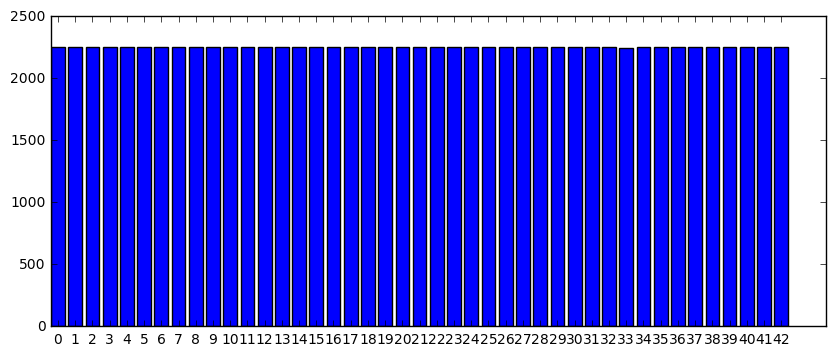

In [8]:
# new plot to see the new distribution
# first we need to recalculate the sign class distribution
code_labels, quantities_per_label = signs_distribution(normalized_y_train)

# the new uniform distribution
plot_histogram(code_labels, quantities_per_label)

Everything seems fine in the training set. Saving the data to files so I can retrieve them later if needed

Also, test data are normalized (grayscale + scaling + centering around zero) so they are compatible with training data

In [9]:
# save new data to file
normalized_data = {'features': normalized_X_train, 'labels': normalized_y_train}
normalized_test = {'features': normalized_X_test, 'labels': y_test}
save_object_to_file(normalized_data, configuration['files']['normalized_training'])
save_object_to_file(normalized_test, configuration['files']['normalized_testing'])
print("data saved!")

data saved!


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

* Data Generation : additional data have been generated so that every sign class has the same number of data. The main reason is to have an unbiased error estimation , else i would have to calculate error per sign class
The new images are generated by rotating and skewing the original image set. Images are picked randomly from the original datase and the required number of them is generated. 

* Training Data, Testing Data, Validation Data: I am splitting the normalized training data in a 90-10 split, in order to monitor if and when the network shows signs of overfitting

First read the data from the files and then create a training and validation set by splitting the training data set by 90-10

We also need a helper function to process data in batches. So the next generator function does the job

In [10]:
# Part 6: Splitting Data Set into Training and Validation Sets

from sklearn.model_selection import train_test_split

normalized_X_train, normalized_y_train, \
    normalized_X_test, normalized_y_test, sign_labels = read_data_from_files(configuration, normalized=True)

# when the images where transformed to grayscale the color channel was squeezed
# we are restoring it again so numpy arrays would be (32,32,1)
normalized_X_train = np.expand_dims(normalized_X_train, axis=3)
normalized_X_test = np.expand_dims(normalized_X_test, axis=3)

# creating a training and a validation set (90-10) to monitor overfitting
normalized_X_train, normalized_X_validation, \
    normalized_y_train, normalized_y_validation = train_test_split(normalized_X_train,
                                                                   normalized_y_train,
                                                                   test_size=0.1,
                                                                   random_state=1000
                                                                   )

print('train-validiation test split done!')

train-validiation test split done!


In [11]:
# data batch generator
def batches(data_dict, b_size):
    """
    A generator to help process the data dictionary in batches
    :param data_dict: the data dictionary. a "x" and "y" keys should exist
    :param b_size: the batch size
    :return: the next batch
    """
    size = len(data_dict['x'])
    start = 0
    end = start + b_size
    while end < size:
        yield data_dict['x'][start:end], data_dict['y'][start:end], b_size
        start = end
        end += b_size
    end = size
    yield data_dict['x'][start:end], data_dict['y'][start:end], end - start

---
### Designing the Network

In [12]:
# Part 7: Network Design

import tensorflow as tf
import time
from datetime import timedelta

* First some helper functions

In [13]:
# Part 7a: helper functions --------------------------------------------------------------------------------------------

def weight_variable(shape, name, mean=0.0, dev=0.05):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, mean=mean, stddev=dev)
    return tf.Variable(initial, name=name)


def bias_variable(length, name, value=0.1):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(value, shape=[length])
    return tf.Variable(initial, name=name)


def conv2d(x_, w, b, strides=1):
    x_ = tf.nn.conv2d(x_, w, strides=[1, strides, strides, 1], padding='SAME')
    x_ = tf.nn.bias_add(x_, b)
    return tf.nn.relu(x_)


def maxpool2d(x_, k=2):
    return tf.nn.max_pool(
        x_,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

### the parameters of the network

* no of output classes
* basic options (where to save, learning rate, batch size)
* layer widths (per layer)
* layer shapes (per layer)
* weight variables (per layer)
* bias variables (per layer)

In [14]:
n_classes = len(sign_labels.keys())

options = {
    'checkpoints_dir': './project.data.checkpoints/',
    'checkpoint_every': 10,
    'step_info_every': 1,
    'learning_rate': 1e-3,
    'batch_size': 128
}

layer_width = {
    'layer_1': 16,
    'layer_2': 32,
    'layer_3': 64,
    'layer_4': 128,
    'fc1': 512,
    'fc2': 256,
    'out': n_classes
}

layer_shapes = {
    'layer_1': [5, 5, 1, layer_width['layer_1']],
    'layer_2': [5, 5, layer_width['layer_1'], layer_width['layer_2']],
    'layer_3': [5, 5, layer_width['layer_2'], layer_width['layer_3']],
    'layer_4': [1, 1, layer_width['layer_3'], layer_width['layer_4']],
    'fc1': [4 * 4 * layer_width['layer_4'], layer_width['fc1']],
    'fc2': [layer_width['fc1'], layer_width['fc2']],
    'out': [layer_width['fc2'], layer_width['out']]
}

# Store layers weight & bias
weights = {
    'layer_1': weight_variable(layer_shapes['layer_1'], name='w1'),
    'layer_2': weight_variable(layer_shapes['layer_2'], name='w2'),
    'layer_3': weight_variable(layer_shapes['layer_3'], name='w3'),
    'layer_4': weight_variable(layer_shapes['layer_4'], name='w4'),
    'fc1': weight_variable(layer_shapes['fc1'], name='wfc1'),
    'fc2': weight_variable(layer_shapes['fc2'], name='wfc2'),
    'out': weight_variable(layer_shapes['out'], name='out')
}

biases = {
    'layer_1': bias_variable(layer_width['layer_1'], name='b1', value=0.0),
    'layer_2': bias_variable(layer_width['layer_2'], name='b2', value=0.0),
    'layer_3': bias_variable(layer_width['layer_3'], name='b3', value=0.0),
    'layer_4': bias_variable(layer_width['layer_4'], name='b4', value=0.0),
    'fc1': bias_variable(layer_width['fc1'], name='bfc1', value=0.0),
    'fc2': bias_variable(layer_width['fc2'], name='bfc2', value=0.0),
    'out': bias_variable(layer_width['out'], name='out', value=0.0)
}

### Network assembling - Tensorflow Graph

The network is assempled using the above parameters + the helper functions

In [15]:
# the convolution neural network
def conv_net(x_, w, b, pr, name='logits'):
    """
    Creating the convolution network
    :param x_: the input
    :param w: the weight dictionary (per layer)
    :param b: the biases (per layer)
    :param pr: probabilities vector for dropout
    :param name: assign the output tf variable a name
    :return: the logits ready for softmax
    """

    # Layer 1 - 32*32*1 to 16*16*16
    conv1 = conv2d(x_, w['layer_1'], b['layer_1'])
    conv1 = maxpool2d(conv1)

    # Layer 2 - 16*16*16 to 8*8*32
    conv2 = conv2d(conv1, w['layer_2'], b['layer_2'])
    conv2 = maxpool2d(conv2)

    # Layer 3 - 8*8*32 to 4*4*64
    conv3 = conv2d(conv2, w['layer_3'], b['layer_3'])
    conv3 = maxpool2d(conv3)

    # Layer 4 - 4*4*64 to 4*4*128
    conv4 = conv2d(conv3, w['layer_4'], b['layer_4'])
    # conv4 = maxpool2d(conv4)
    # conv4 = tf.nn.dropout(conv4, pr)

    # Fully connected layer - 4*4*128 to 1024
    # Reshape conv4 output to fit fully connected layer1 input
    fc1 = tf.reshape(conv4, [-1, w['fc1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, w['fc1']), b['fc1'])
    fc1 = tf.nn.relu(fc1)

    fc2 = tf.add(tf.matmul(fc1, w['fc2']), b['fc2'])
    fc2 = tf.nn.relu(fc2)

    out = tf.add(tf.matmul(fc2, w['out']), b['out'], name=name)

    return out

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I started with the LeCun network and gradually increased the filters (first) and later added more layers to get better results
My network looks as follows after some experimentation

* input  (32x32x01) -> (32x32x01)
* layer1 016x(5x5x01) filters ->  (32x32x016) -> maxpool -> (16x16x16)
* layer2 032x(5x5x16) filters ->  (16x16x032) -> maxpool -> (08x08x32)
* layer3 064x(5x5x32) filters ->  (08x08x064) -> maxpool -> (04x04x64)
* layer4 128x(1x1x64) filters ->  (04x04x128) -> flatten -> (2048,)
* fc1 (2048,) -> (512,) 
* fc2 (0512,) -> (256,)
* out (0256,) -> (043,) 

### Completing the Tensorflow graph 

* placeholders and variables

In [16]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='input')
y_ = tf.placeholder(tf.int32, shape=[None], name='labels')
y_onehot = tf.one_hot(y_, n_classes, name="one_hot_labels")
keep_prob = tf.placeholder('float', name='keep_prob')

# Create the ConvNet
y = conv_net(x, weights, biases, keep_prob, name='soft_prediction')
y_softmax = tf.nn.softmax(y, name="softmax_probabilities")

# Compute predicted class
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_onehot))
train_step = tf.train.AdamOptimizer(options['learning_rate']).minimize(cross_entropy)

# the prediction the model give (label)
prediction = tf.argmax(y, 1, name='prediction')
# is the prediction correct? : true or false
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_onehot, 1), name="is_correct")
# average correct predictions
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
# is the prediction correct in top5 sense? : true or false
correct_top5_prediction = tf.nn.in_top_k(y, y_, 5, "is_correct_top5")
# average top 5 accuracy
topFiver = tf.reduce_mean(tf.cast(correct_top5_prediction, tf.float32), name="accuracy_top5")
# certainty distribution. top 2
certainty = tf.nn.top_k(y, k=2)

tf_graph = {'input': x,
            'label': y_,
            'soft_prediction': y,
            'prediction': prediction,
            'is_correct': correct_prediction,
            "is_correct_top5": correct_top5_prediction,
            'loss': cross_entropy,
            'optimizer': train_step,
            'accuracy': accuracy,
            'accuracy_top5': topFiver,
            'best2': certainty,
            "keep_prob": keep_prob,
            "softmax_probabilities": y_softmax
            }

### Helper functions that are used in train() function

In [17]:
def print_iteration(i, t):
    """
    Helper print function
    :param i: iteration
    :param t: elapsed time till ith iteration
    :return:
    """
    print("Iteration: {0:>6}".format(i + 1))
    print("Elapsed Time: " + str(timedelta(seconds=int(round(t)))))
    

def train_accuracy(sess, graph, data, config):
    """
    With the results of a session calculate the accuracy of the training model
    in the data dictionary
    :param sess: the session
    :param graph: the tensorflow graph
    :param data: the data dictionary. 'x' and 'y' keys are presumed
    :param config: any parameters needed are passed in this dictionary. i.e batch size
    :return: returns the loss and precision of the model on the data
    """
    batch_size = config['batch_size']
    num_examples = len(data['x'])

    loss, accurate, top5 = 0., 0., 0.

    for b_x, b_y, s in batches(data, batch_size):
        l, a, t = sess.run([graph['loss'],
                            graph['accuracy'],
                            graph['accuracy_top5']],
                           feed_dict={x: b_x, y_: b_y, keep_prob: 1.0}
                           )
        loss, accurate, top5 = loss + l * s, accurate + a * s, top5 + t * s

    loss, precision, top5 = loss / num_examples, accurate / num_examples, top5 / num_examples

    msg = "Num examples: {0:>8}  Correct Predictions: {1:>8.0f}  Precision: {2:6.2%} Top5 Precision: {3:6.2%}"
    print(msg.format(num_examples, accurate, precision, top5))
    return loss, precision

* here is the main training function

In [18]:
def train(sess, the_saver, graph, iterations, tr_data, v_data, config, file_name='traffic', save_if=0.0):
    """
    The main training function of a network
    :param sess: the active session
    :param the_saver: the saver object to save and restore checkpoints
    :param graph: the tensorflow graph
    :param iterations: number of iterations to run the training loop
    :param tr_data: the training data dictionary
    :param v_data: the validation data dictionary
    :param config: the general parameters . i.e where to save, batch size, learning rate etc
    :param file_name: the filename of the checkpoint
    :param save_if: the loop saves when a better accuracy is achieved. Initially its 0.0.
            If we restart training from a saved checkpoint this is tells the algorithm not to save
            if the accuracy is not greater then this value
    :return: Two (2) lists that monitor the accuracy of the training and validation data set while training
    """
    save_path = config['checkpoints_dir'] + file_name
    batch_size = config['batch_size']

    # monitoring loss and accuracy so we can plot later
    acc_train = []
    acc_validation = []

    # read data from latest checkpoint if available
    # recover the global training step and then iterate from there on
    ckpt = tf.train.get_checkpoint_state(config['checkpoints_dir'])
    if ckpt and ckpt.model_checkpoint_path:
        # Restores from checkpoint
        the_saver.restore(sess, ckpt.model_checkpoint_path)
        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/cifar10_train/model.ckpt-0,
        # extract global_step from it.
        global_step = int(ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1])
    else:
        print('No checkpoint file found. Starting from scratch')
        global_step = 0

    # Start Training Loop
    start_time = time.time()
    for step in range(iterations):
        # Loop over all batches
        for b_x, b_y, s in batches(tr_data, batch_size):
            # Run optimization op (backpropagation) and cost op (to get loss value)
            sess.run(graph['optimizer'], feed_dict={x: b_x, y_: b_y})

        # Display logs per epoch step
        duration = time.time() - start_time
        print_iteration(step, duration)
        l, a = train_accuracy(sess, graph, v_data, config)

        # Save if better accuracy
        if a > save_if:
            print("Creating Checkpoint -----------------------------------")
            the_saver.save(sess, save_path, global_step=global_step + step + 1)
            print("Training Accuracy: ")
            acc_train.append(train_accuracy(sess, graph, tr_data, config))
            print("Validation Accuracy")
            acc_validation.append(train_accuracy(sess, graph, v_data, config))
            save_if = a

    print("Optimization Finished!")
    return acc_train, acc_validation

Creating the data dictionaries that we will use to feed the model

In [19]:
# training, validation & test data in dictionaries
train_dict = {
    'x': normalized_X_train,
    'y': normalized_y_train
}

validation_dict = {
    'x': normalized_X_validation,
    'y': normalized_y_validation
}

test_dict = {
    'x': normalized_X_test,
    'y': normalized_y_test
}  # init variables

Create the session and the saver object and init variables

In [20]:
session = tf.Session()
saver = tf.train.Saver()
session.run(tf.global_variables_initializer())

In [78]:
### Train your model here.

training_results_plt = []
validation_results_plt = []

t, v = train(session, saver, tf_graph, 40, train_dict, validation_dict, options, save_if=0.0)
training_results_plt += t
validation_results_plt += v

training_loss, training_accuracy = zip(*training_results_plt)
validation_loss, validation_accuracy = zip(*validation_results_plt)

No checkpoint file found. Starting from scratch
Iteration:      1
Elapsed Time: 0:01:49
Num examples:     9675  Correct Predictions:     7466  Precision: 77.17% Top5 Precision: 95.66%
Creating Checkpoint -----------------------------------
Training Accuracy: 
Num examples:    87074  Correct Predictions:    68175  Precision: 78.30% Top5 Precision: 96.18%
Validation Accuracy
Num examples:     9675  Correct Predictions:     7466  Precision: 77.17% Top5 Precision: 95.66%
Iteration:      2
Elapsed Time: 0:04:30
Num examples:     9675  Correct Predictions:     8772  Precision: 90.67% Top5 Precision: 98.79%
Creating Checkpoint -----------------------------------
Training Accuracy: 
Num examples:    87074  Correct Predictions:    80021  Precision: 91.90% Top5 Precision: 99.16%
Validation Accuracy
Num examples:     9675  Correct Predictions:     8772  Precision: 90.67% Top5 Precision: 98.79%
Iteration:      3
Elapsed Time: 0:07:15
Num examples:     9675  Correct Predictions:     8936  Precision

Plotting the accuracy progress during training

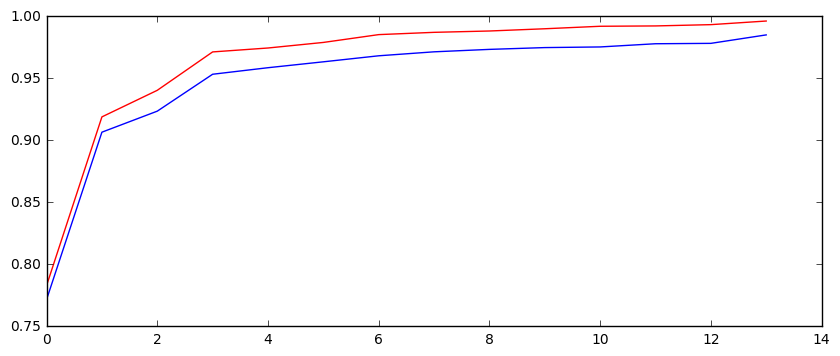

In [79]:
plt.figure(figsize=(10, 4), dpi=80)
plt.plot(training_accuracy, 'r-', validation_accuracy, 'b-')
plt.show()

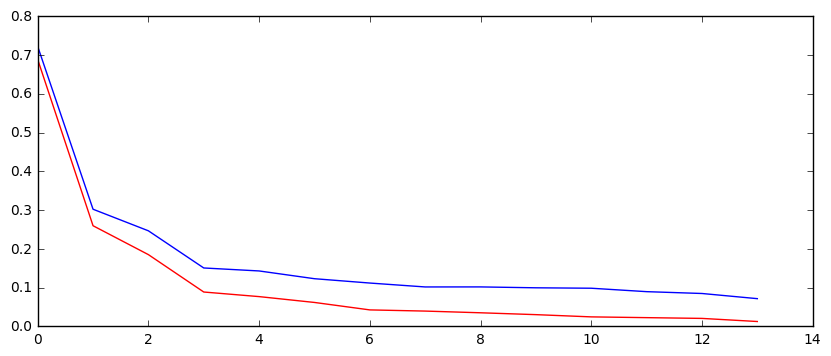

In [80]:
plt.figure(figsize=(10, 4), dpi=80)
plt.plot(training_loss, 'r-', validation_loss, 'b-')
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* I used the AdamOptimizer to train the model.

* With the Batch size i had some problems. At first I went for a big batch size and everything went wrong. Nothing worked and the network completely diverged. After a lot of debugging the only thing left was the batch size. Lowered it down to 128 images per batch and everything worked perfectly

* I used 40 training epochs, storing checkpoints each time there was an improvement in the model accuracy in the validation test

* Learning Rate was set to 0.001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

There was a lot of trial and error. I started with the LeCun network, since both it was suggested and it was the logical choice to go for an image classifying network.

After i fixed my problems with the batch size , i started playing first with the size of the first connected layer, seeing obvious improvements in the results. Then gradually i increased the number of filters in the convolutional layers watching the results i got.

Finally I added more layers and a 1x1 convolution layer at the end that increased a little bit more the accuracy

### lets first restore the session with the last checkpoint

In [38]:
saver.restore(session, './project.data.checkpoints/traffic-40')

### Let's see how the model does in the **TESTING SET**

In [39]:
train_accuracy(session, tf_graph, test_dict, options)

Num examples:    12630  Correct Predictions:    11539  Precision: 91.36% Top5 Precision: 97.97%


(0.92378962776156903, 0.91361836895334847)


and lets see some sample misclassified images


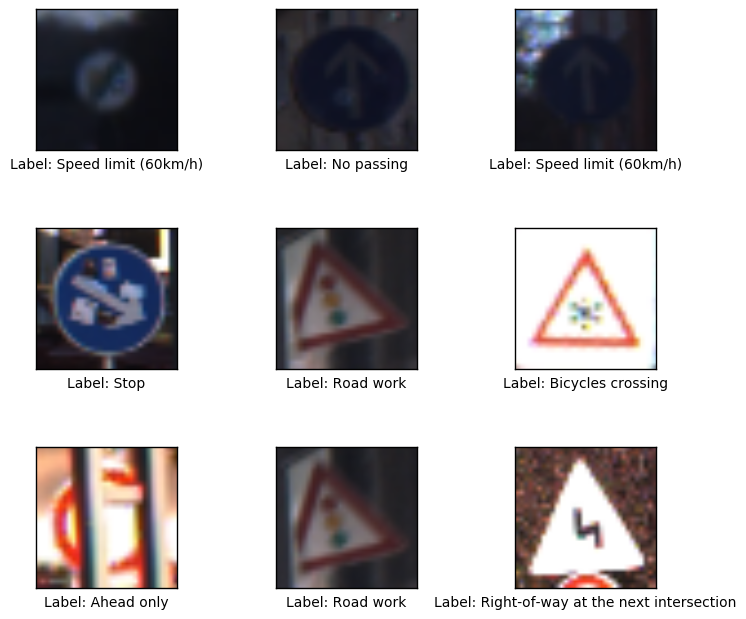

In [42]:
def misclassified_images(sess, graph, data, config, top5=False):
    batch_size = config['batch_size']
    num_examples = len(data['x'])

    correct = np.zeros(shape=num_examples, dtype=int)
    predict = np.zeros(shape=num_examples, dtype=int)
    start, end = 0, 0

    for b_x, b_y, s in batches(data, batch_size):
        end = start + s
        if top5:
            correct[start: end], predict[start: end] = sess.run([graph['is_correct_top5'],
                                                                 graph['prediction']],
                                                                feed_dict={x: b_x, y_: b_y, keep_prob: 1.0})
        else:
            correct[start: end], predict[start: end] = sess.run([graph['is_correct'],
                                                                 graph['prediction']],
                                                                feed_dict={x: b_x, y_: b_y, keep_prob: 1.0})
        start = end
    return correct, predict




is_correct, lbl = misclassified_images(session, tf_graph, test_dict, options, top5=True)
plot_random_images(images=np.squeeze(X_test[is_correct == False]),
                   rows=3, columns=3,
                   labels=lbl[is_correct == False],
                   captions=sign_labels,
                   cmap='Greys_r')

### Plot Success Per Sign Category

* test data

class:   0                               Speed limit (20km/h)     items:     60    accuracy:  85.00%    top5: 100.00%
class:   1                               Speed limit (30km/h)     items:    720    accuracy:  96.81%    top5:  99.86%
class:   2                               Speed limit (50km/h)     items:    750    accuracy:  98.27%    top5: 100.00%
class:   3                               Speed limit (60km/h)     items:    450    accuracy:  94.00%    top5:  99.33%
class:   4                               Speed limit (70km/h)     items:    660    accuracy:  90.15%    top5:  96.97%
class:   5                               Speed limit (80km/h)     items:    630    accuracy:  85.56%    top5:  99.37%
class:   6                        End of speed limit (80km/h)     items:    150    accuracy:  80.00%    top5:  86.00%
class:   7                              Speed limit (100km/h)     items:    450    accuracy:  90.67%    top5:  98.67%
class:   8                              Speed limit (120

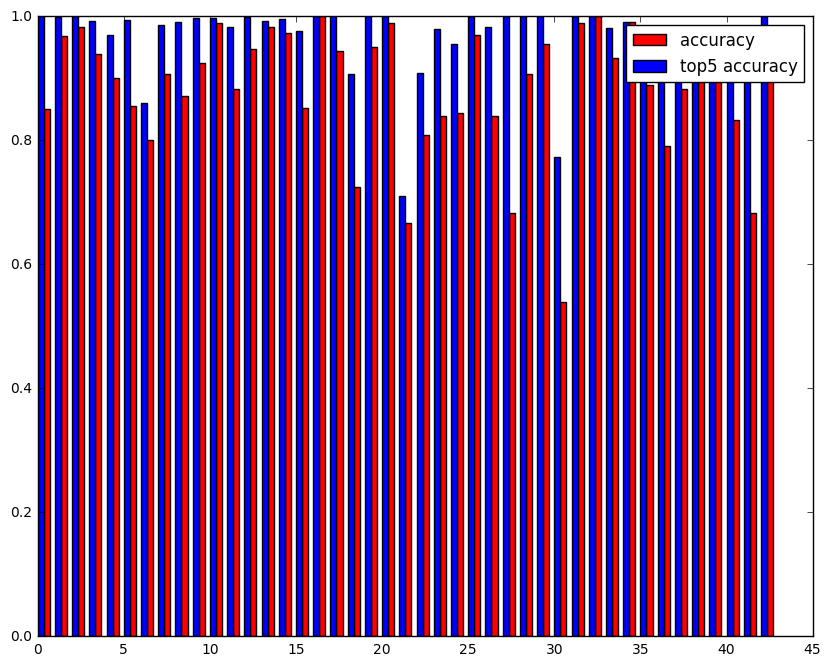

In [43]:
def success_per_class(n_cat, sess, graph, data, sign_labels, config):
    per_class = []
    msg = "class: {0:>3} {4:>50}     items: {1:>6}    accuracy: {2:>7.2%}    top5: {3:>7.2%}"
    x = graph['input']
    y_ = graph['label']
    keep_prob = graph['keep_prob']

    for j in range(n_cat):
        batch_size = config['batch_size']
        mask = (data['y'] == j)
        masked_data = {'x': data['x'][mask], 'y': data['y'][mask]}
        num_items = len(data['x'][mask])
        cat_accuracy, cat_t5_accuracy = 0., 0.

        for b_x, b_y, s in batches(masked_data, batch_size):
            ac, t5 = sess.run([graph['accuracy'],
                               graph['accuracy_top5']],
                              feed_dict={x: b_x, y_: b_y, keep_prob: 1.0})
            cat_accuracy, cat_t5_accuracy = cat_accuracy + ac * s, cat_t5_accuracy + t5 * s

        per_class.append((cat_accuracy / num_items, cat_t5_accuracy / num_items))
        print(msg.format(j, num_items, cat_accuracy / num_items, cat_t5_accuracy / num_items, sign_labels[j]))
    return per_class



fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
acc, tt5 = zip(*success_per_class(n_classes, session, tf_graph, test_dict, sign_labels, options))
bar_acc = ax.bar(np.arange(n_classes) + 0.35, acc, width=0.35, color='r')
bar_t5 = ax.bar(np.arange(n_classes), tt5, width=0.35, color='b')
ax.legend( (bar_acc[0], bar_t5[0]), ('accuracy', 'top5 accuracy') )
plt.show()

## Lets not see how certain is the model about its decision


In [44]:
def certain_in_class(n, sess, data, graph):
    x = graph['input']
    y_ = graph['label']
    keep_prob = graph["keep_prob"]
    dx = data['x']
    dy = data['y']
    a = sess.run(graph['best2'],
                 feed_dict={x: dx[dy == n],
                            y_: dy[dy == n],
                            keep_prob: 1.0}
                 )
    how_certain = abs(a[0][:, 0] - a[0][:, 1])
    items = len(how_certain)
    how_certain_1p = (how_certain < 1).sum()
    how_certain_5p = (how_certain < 5).sum()
    how_certain_10p = (how_certain < 10).sum()
    how_certain_15p = (how_certain < 15).sum()
    how_certain_20p = (how_certain < 20).sum()
    s = how_certain_1p + how_certain_5p + how_certain_10p + how_certain_15p + how_certain_20p
    # scaling to make comparison between classes possible
    return [how_certain_1p / s, how_certain_5p / s, how_certain_10p / s, how_certain_15p / s, how_certain_20p / s]


def certain_in_classes(sess, data, graph, n):
    cc = []
    for i in range(n):
        cc.append(certain_in_class(i, sess, data, graph))
    return list(zip(*cc))


def plot_certainty_per_class(sess, data, graph, n, width=0.35):
    bars = certain_in_classes(sess, data, graph, n)  # 5 bars
    ind = np.arange(n)
    width = 0.35

    pl = []  # the plots
    colors = ['r', 'y', 'm', 'b', 'g']  # the colors per bar stack

    plt.figure(figsize=(10, 8), dpi=80)
    for i in range(len(bars)):
        if i == 0:
            pl.append(plt.bar(ind, bars[i], width, color=colors[i]))
            bottom = np.asarray(bars[i])  # save the previous bar so it can sit on the bottom of the next one
        else:
            pl.append(plt.bar(ind, bars[i], width, bottom=bottom, color=colors[i]))
            bottom += np.asarray(bars[i])
    plt.legend((pl[0][0], pl[1][0], pl[2][0], pl[3][0], pl[4][0]), ('1%', '5%', '10%', '15%', '20%'))
    
    plt.show()

The  plot shows the difference between the prediction and the next best guess in percents.
The percents are normalized to sum to 1 in order to get a sense of distribution.

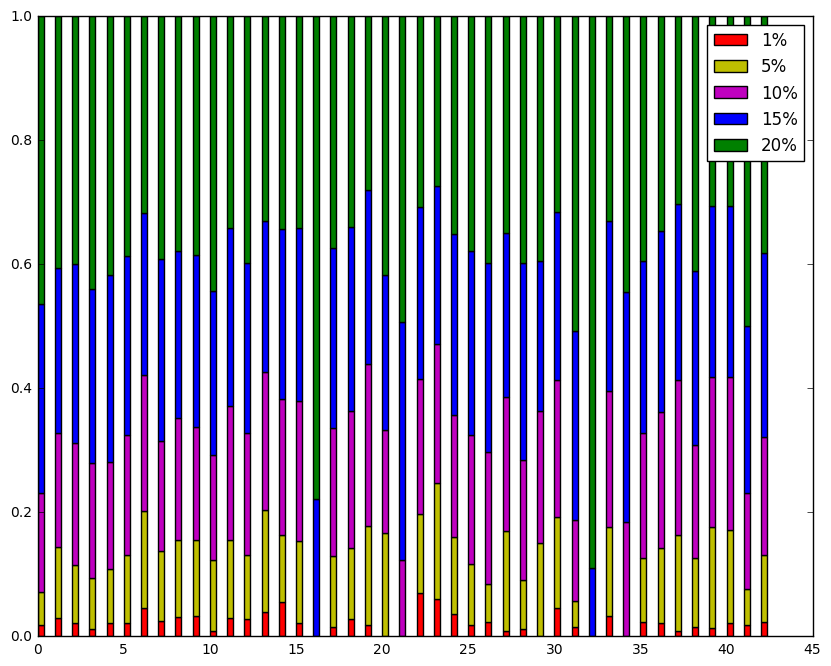

In [45]:
plot_certainty_per_class(session, test_dict, tf_graph, n_classes)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

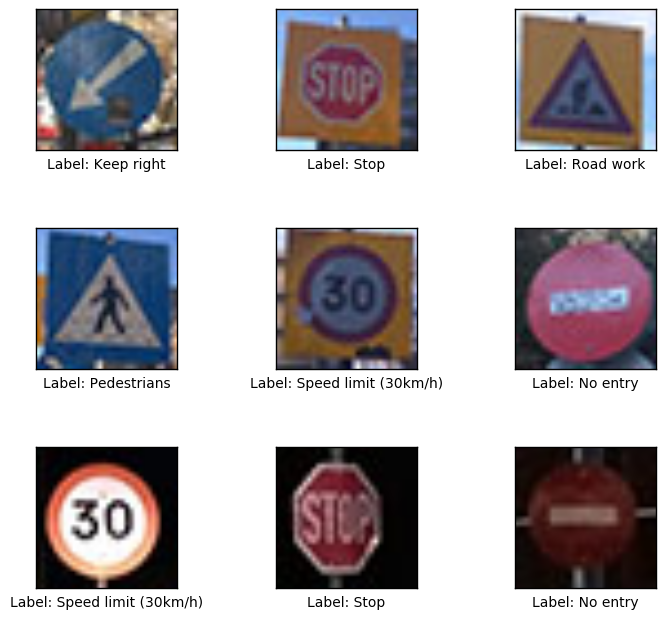

In [50]:
### Load the images and plot them here.

import glob

dir_glob = 'project.signs.extra/*.jpg'

def load_image(file_name):
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_images(glob_pattern):
    filelist = glob.glob(glob_pattern)
    return np.array([np.array(load_image(f_name)) for f_name in filelist])

imgs = load_images(dir_glob)
lbls = np.array([1,1,14,14,17,17,25,27,38,38,40])

plot_random_images(imgs,3,3,lbls,sign_labels)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The images are not from the internet. I took them while going out on a ride. There are simple and very common signs BUT i wanted to test how background and placement of the sign and light conditions (day - night) affect the prediction

So i have a pair of speed limit signs (in different background and night and day versions) , the same also for stop signs, and a no-entry sign at night. There are the most common signs you see in everyday life.

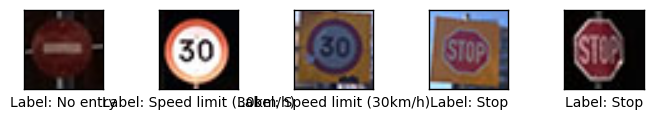

In [47]:
mask = np.array([True, True, True, True, True, False, False, False, False, False, False])

plot_random_images(imgs[mask], 1, 5, lbls[mask], sign_labels)

### first normalize the data and create the data dictionary that is needed

In [51]:
### Run the predictions here.

# first normalize the images and create the dictionary

normalized_imgs = np.expand_dims(pre_process_dataset(imgs), axis=3)

extra_set = {'x': normalized_imgs[mask], 'y': lbls[mask]}

### apply the model and first see the accuracy of the predictions

In [49]:
train_accuracy(session,tf_graph,extra_set,options)

Num examples:        5  Correct Predictions:        4  Precision: 80.00% Top5 Precision: 80.00%


(3.5263168811798096, 0.80000001192092896)

### so at first i get 4 out of 5 predictions correct and one is wrong. lets see it visually


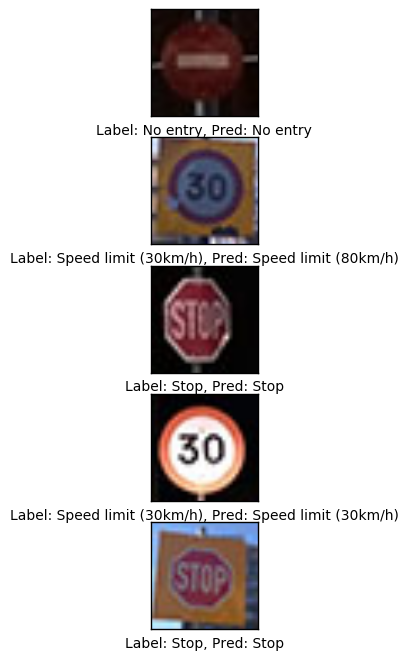

In [52]:
pred = session.run(tf_graph['prediction'],
                   feed_dict={tf_graph['input']: extra_set['x'],
                              tf_graph['label']: extra_set['y'],
                              tf_graph['keep_prob']: 1.0})

plot_random_images(imgs[mask], 5, 1, lbls[mask], sign_labels, pred)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 

it does very well, considering the small sample, and basically misses the 3 for an 8 which can be due to the quality of the image.

I also think that at night, with the normal light of my motorcycle (or any other vechicle) you get a better result.

#### now how does it compare to the test accuary?

Let the statistics answer that for us. We have:

* N = 5 (sample size)
* μ = 0.8
* σ = sqrt( [4*(1-0.8)^2 + (0-0.8)^2]/N-1 ) = 0.11

so looking to the **t-tables** for a 95% confidence interval we get that the **polulation accuracy** is within [0.6634 , 0.9366], which is compatible with the results the test sample gave us.

So what the results of this small sample are well within the expected results.

p.s : actually doing the same math for the test accuracy we get that the expected accuracy is within [0.9084, 0.9188] 


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The answer is show below for each image

### Now let's see how 'easy' and confident is the prediction made by the model

In [72]:
### Visualize the softmax probabilities here.


# will be using this function to understand what is going on

def plot_confidence_per_image(sess, graph, data, image_number):
    x = graph['input']
    y_ = graph['label']
    pr = graph["keep_prob"]
    dx = data['x']
    dy = data['y']
    a = sess.run(tf.nn.top_k(graph['softmax_probabilities'], k=3),
                 feed_dict={x: dx[image_number:image_number + 1],
                            y_: dy[image_number:image_number + 1],
                            pr: 1.0}
                 )

    possible_signs = a[1][0]
    labels = [sign_labels[sign] for sign in possible_signs]
    possible_signs_softmax_probabilities = a[0][0]
    # print(possible_signs_softmax_probabilities)
    explode = (0.1, 0.0, 0.0)

    plt.figure(1, figsize=(5, 5))
    ax = plt.axes([0.1, 0.1, 0.5, 0.5])

    patches, texts, autotexts = plt.pie(possible_signs_softmax_probabilities,
                                        explode=explode,
                                        labels=labels,
                                        autopct='%1.1f%%',
                                        shadow=True,
                                        startangle=90,
                                        labeldistance=1.1,
                                        pctdistance=0.6)

    for t in autotexts:
        t.set_color('w')

    plt.legend(patches, labels)
    plt.legend(bbox_to_anchor=(1.15, 1.15), loc=2, borderaxespad=0.)

    plt.show()

## image - 1


**prediction** -> correct

**result** -> very confident

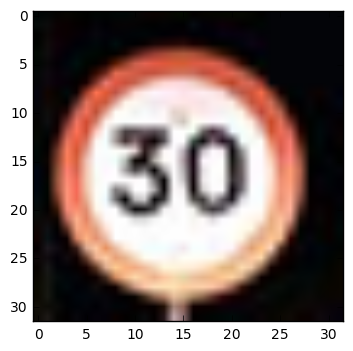

In [79]:
plt.imshow(imgs[0])

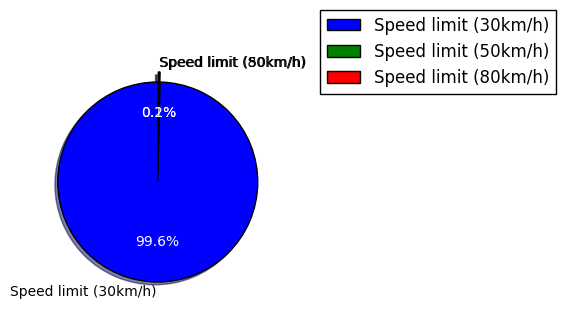

In [80]:
plot_confidence_per_image(session,tf_graph,extra_set,0)

## image - 2

**prediction** -> wrong (maybe the non standard version the sign is the problem and maybe tighter crop would help. on the other hand the model its **certain** its a km/h sign, so that means it understand the **pattern**. Maybe a deeper network even without any localization algorithms would predict that correct too.

**result** -> very confident

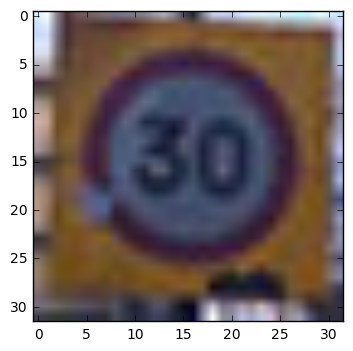

In [81]:
plt.imshow(imgs[1])

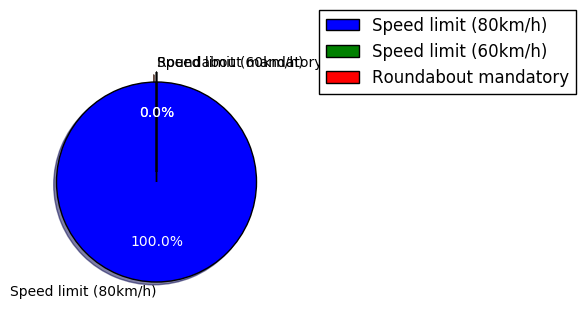

In [74]:
plot_confidence_per_image(session,tf_graph,extra_set,1)

## image - 3

**prediction** -> correct  (although its night and the sign is smudged)

**result** -> very confident

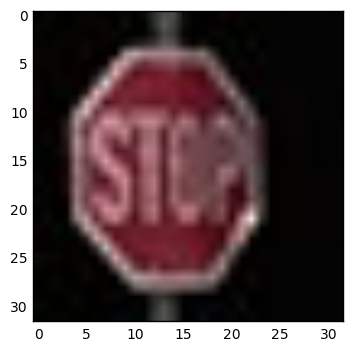

In [82]:
plt.imshow(imgs[2])

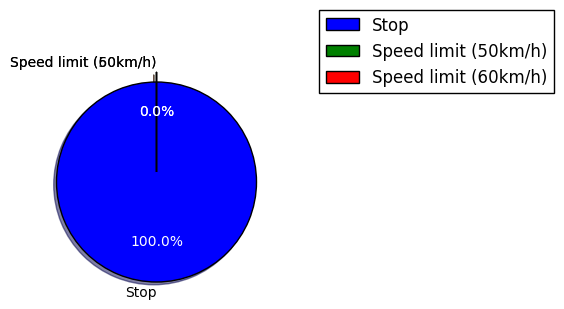

In [75]:
plot_confidence_per_image(session,tf_graph,extra_set,2)

## image - 4

**prediction** -> correct  (this is also a non standard sign so probably this is why its a harder choice)

**result** -> not confident

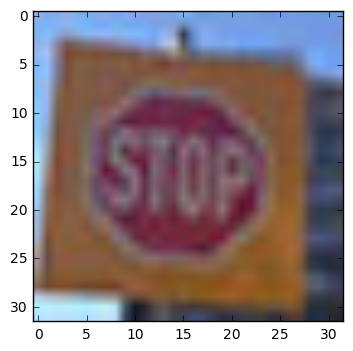

In [83]:
plt.imshow(imgs[3])

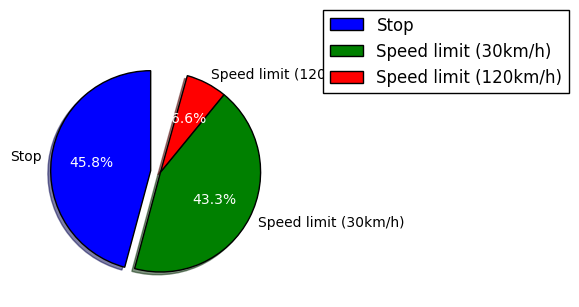

In [76]:
plot_confidence_per_image(session,tf_graph,extra_set,3)

## image - 5

**prediction** -> correct

**result** -> very confident

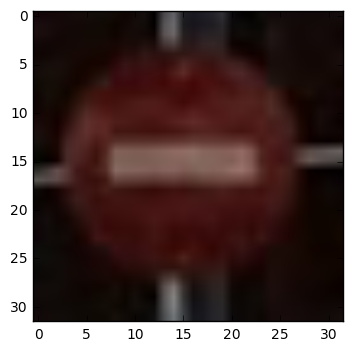

In [84]:
plt.imshow(imgs[4])

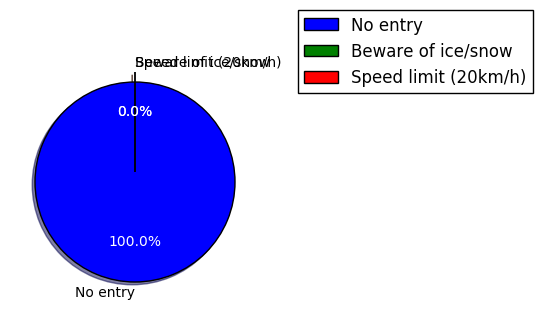

In [77]:
plot_confidence_per_image(session,tf_graph,extra_set,4)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.